## Preprocessing and merging the derived level 3 atmospheric readings with the derived level 3 surface emission datasets

In [2]:
import pandas as pd
import re
import numpy as np
import rasterio

### Read Datasets

In [2]:
# Preview lsemiss dataset since it cannot be fully read with pandas on google colab due to its size
chunk_size = 20000


# Preview the first chunk of surface emission to determine the columns to retain so as to reduce the size of the dataframes
for chunk in pd.read_csv('new_dataset/emm_emr_l3emiss.csv', chunksize=chunk_size):
    chunk.info()
    break;


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                20000 non-null  int64  
 1   emissivity                20000 non-null  object 
 2   kinetic_temp              20000 non-null  float64
 3   kinetic_temp_uncertainty  20000 non-null  float64
 4   kinetic_temp_wave         20000 non-null  float64
 5   utc                       20000 non-null  object 
 6   latitude                  20000 non-null  float64
 7   longitude                 20000 non-null  float64
dtypes: float64(5), int64(1), object(2)
memory usage: 1.2+ MB


In [3]:
# Read surface emissions readings dataset in chunks due to the size of the combined dataset
# Cleaning the read chunks by dropping unwanted columns and removing records without geolocation (Latitude and Longitude)
chunk_size = 200000
chunks = []
count = 1

# Read the CSV file in chunks
for chunk in pd.read_csv('new_dataset/emm_emr_l3emiss.csv', chunksize=chunk_size):
    print(f'processing chunk {count}')

    # Dropped unwanted columns
    chunk = chunk.drop(columns=['Unnamed: 0'])

    # Dropped columns with undefined latitude and longitude
    chunk = chunk[(chunk['latitude'] != 0) & (chunk['longitude'] != 0)]

    # Append cleaned chunks
    chunks.append(chunk)
    count = count + 1

l3emiss_df = pd.concat(chunks, ignore_index=True)
l3emiss_df.info()

processing chunk 1
processing chunk 2
processing chunk 3
processing chunk 4
processing chunk 5
processing chunk 6
processing chunk 7
processing chunk 8
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1253317 entries, 0 to 1253316
Data columns (total 7 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   emissivity                1253317 non-null  object 
 1   kinetic_temp              1253317 non-null  float64
 2   kinetic_temp_uncertainty  1253317 non-null  float64
 3   kinetic_temp_wave         1253317 non-null  float64
 4   utc                       1253317 non-null  object 
 5   latitude                  1253317 non-null  float64
 6   longitude                 1253317 non-null  float64
dtypes: float64(5), object(2)
memory usage: 66.9+ MB


In [4]:
l3emiss_df.dtypes

emissivity                   object
kinetic_temp                float64
kinetic_temp_uncertainty    float64
kinetic_temp_wave           float64
utc                          object
latitude                    float64
longitude                   float64
dtype: object

In [5]:
l3emiss_df.shape

(1253317, 7)

In [6]:
## Read atmospheric readings dataset
l3atm_df = pd.read_csv("new_dataset/emm_emr_l3atm.csv")
l3atm_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2362746 entries, 0 to 2362745
Data columns (total 36 columns):
 #   Column                Dtype  
---  ------                -----  
 0   Unnamed: 0            int64  
 1   utc                   object 
 2   temp                  object 
 3   tsurfco2              float64
 4   chi2temp              float64
 5   pres0                 float64
 6   taudust               float64
 7   tauice                float64
 8   tsurfa                float64
 9   dustuncert            float64
 10  iceuncert             float64
 11  chi2a                 float64
 12  prum                  float64
 13  tsurfh2o              float64
 14  wateruncert           float64
 15  chi2b                 float64
 16  tsurf                 float64
 17  dustgood              float64
 18  icegood               float64
 19  watergood             float64
 20  tempgood              float64
 21  tsurfgood             float64
 22  latitude              float64
 23  longitu

In [7]:
l3atm_df.shape

(2362746, 36)

In [8]:
## Remove unwanted columns
l3atm_df = l3atm_df.drop(columns=['Unnamed: 0.2', 'Unnamed: 0', 'Unnamed: 0.3', 'Unnamed: 0.4', 'Unnamed: 0.5', 'Unnamed: 0.6', 'Unnamed: 0.7'])


In [9]:
l3atm_df.shape

(2362746, 29)

In [10]:
l3atm_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2362746 entries, 0 to 2362745
Data columns (total 29 columns):
 #   Column                Dtype  
---  ------                -----  
 0   utc                   object 
 1   temp                  object 
 2   tsurfco2              float64
 3   chi2temp              float64
 4   pres0                 float64
 5   taudust               float64
 6   tauice                float64
 7   tsurfa                float64
 8   dustuncert            float64
 9   iceuncert             float64
 10  chi2a                 float64
 11  prum                  float64
 12  tsurfh2o              float64
 13  wateruncert           float64
 14  chi2b                 float64
 15  tsurf                 float64
 16  dustgood              float64
 17  icegood               float64
 18  watergood             float64
 19  tempgood              float64
 20  tsurfgood             float64
 21  latitude              float64
 22  longitude             float64
 23  sc_alti

**bold text**### Helper methods

In [11]:
## Helper Methods
def object_columns_converter(data_string):
    float_values = [float(val) for val in re.findall(r'\d+\.\d+', data_string)]
    if len(float_values) == 0:
        return 0
    else:
        return sum(float_values) / len(float_values)

### Cleaning columns with similar data formats
It was observed that `temp` column have the data format that needs to be converted.

In [12]:
## Clean object columns
l3atm_df['temp'] = l3atm_df['temp'].apply(object_columns_converter)

## Convert utc to timestamp for the derived atmospheric readings dataset
l3atm_df['utc'] = pd.to_datetime(l3atm_df['utc'], format='mixed')

## Convert utc to timestamp for the derived derived surface emissions readings dataset
l3emiss_df['utc'] = pd.to_datetime(l3emiss_df['utc'], format='mixed')

In [14]:
# l3atm_df = l3atm_df.replace(0,np.nan)
l3atm_df = l3atm_df[l3atm_df['temp'] != np.nan]
l3atm_df = l3atm_df[l3atm_df['temp'].notna()]

In [15]:
l3atm_df.shape

(2362746, 29)

In [16]:
l3atm_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2362746 entries, 0 to 2362745
Data columns (total 29 columns):
 #   Column                Dtype         
---  ------                -----         
 0   utc                   datetime64[ns]
 1   temp                  float64       
 2   tsurfco2              float64       
 3   chi2temp              float64       
 4   pres0                 float64       
 5   taudust               float64       
 6   tauice                float64       
 7   tsurfa                float64       
 8   dustuncert            float64       
 9   iceuncert             float64       
 10  chi2a                 float64       
 11  prum                  float64       
 12  tsurfh2o              float64       
 13  wateruncert           float64       
 14  chi2b                 float64       
 15  tsurf                 float64       
 16  dustgood              float64       
 17  icegood               float64       
 18  watergood             float64       
 19  

In [17]:
l3atm_df.shape

(2362746, 29)

In [18]:
l3atm_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2362746 entries, 0 to 2362745
Data columns (total 29 columns):
 #   Column                Dtype         
---  ------                -----         
 0   utc                   datetime64[ns]
 1   temp                  float64       
 2   tsurfco2              float64       
 3   chi2temp              float64       
 4   pres0                 float64       
 5   taudust               float64       
 6   tauice                float64       
 7   tsurfa                float64       
 8   dustuncert            float64       
 9   iceuncert             float64       
 10  chi2a                 float64       
 11  prum                  float64       
 12  tsurfh2o              float64       
 13  wateruncert           float64       
 14  chi2b                 float64       
 15  tsurf                 float64       
 16  dustgood              float64       
 17  icegood               float64       
 18  watergood             float64       
 19  

In [19]:
l3emiss_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1253317 entries, 0 to 1253316
Data columns (total 7 columns):
 #   Column                    Non-Null Count    Dtype         
---  ------                    --------------    -----         
 0   emissivity                1253317 non-null  object        
 1   kinetic_temp              1253317 non-null  float64       
 2   kinetic_temp_uncertainty  1253317 non-null  float64       
 3   kinetic_temp_wave         1253317 non-null  float64       
 4   utc                       1253317 non-null  datetime64[ns]
 5   latitude                  1253317 non-null  float64       
 6   longitude                 1253317 non-null  float64       
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 66.9+ MB


In [20]:
## Merge dataframes into one
merged_df = pd.merge(l3atm_df, l3emiss_df, on=['utc', 'longitude', 'latitude'])
merged_df.shape

(1361113, 33)

In [21]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1361113 entries, 0 to 1361112
Data columns (total 33 columns):
 #   Column                    Non-Null Count    Dtype         
---  ------                    --------------    -----         
 0   utc                       1361113 non-null  datetime64[ns]
 1   temp                      1361113 non-null  float64       
 2   tsurfco2                  1359469 non-null  float64       
 3   chi2temp                  1361113 non-null  float64       
 4   pres0                     1361113 non-null  float64       
 5   taudust                   1361113 non-null  float64       
 6   tauice                    1361113 non-null  float64       
 7   tsurfa                    1359469 non-null  float64       
 8   dustuncert                1361113 non-null  float64       
 9   iceuncert                 1361113 non-null  float64       
 10  chi2a                     1361113 non-null  float64       
 11  prum                      1361113 non-null  float6

In [22]:
## Inspect emissivity
merged_df['emissivity'][1]

'[  0.           0.           0.           0.           0.\n   0.           1.64448917   0.31691214   1.23232079   0.57384109\n   0.94663978   0.69069391   0.97178501   0.7893185    0.89216727\n   0.8073324    0.88165158   0.83483398   0.90071279   0.85872519\n   0.8921622    0.88280368   0.91140896   0.90539032   0.90758348\n   0.91478574   0.93000686   0.90658164   0.92977899   0.90718323\n   0.91426271   0.89043939   0.91077471   0.90024102   0.90508997\n   0.8928166    0.89770937   0.89810836   0.88973391   0.89376819\n   0.89476317   0.89712048   0.8942374    0.89786047   0.90630269\n   0.90018421   0.89902431   0.9102363    0.91290885   0.90798485\n   0.94358557   0.93948144   0.94205159   0.96785671   1.01205492\n   1.0341692    1.06626654   1.03001368   0.99744976   0.878106\n   0.67056769   0.6303736    0.55161041   0.56815654   0.65436101\n   0.75252688   1.04538715   1.02975309   1.0975647    1.12746501\n   1.06817889   1.02613938   0.98525012   0.95151889   0.98423457\n   0

In [23]:
## Dropped emissivity as it does not correspond to the data format specified in the documentation and is not considered in the research
## Also dropped  tsurfco2, tsurfa, chi2b, temp_quality_flag, taudust_quality_flag, tauice_quality_flag, prum_quality_flag, tsurfa_quality_flag due to all it's vallues being null
merged_df.drop(columns=['tsurfco2', 'tsurfa', 'chi2b', 'temp_quality_flag', 'taudust_quality_flag', 'tauice_quality_flag', 'prum_quality_flag', 
                        'tsurfa_quality_flag', 'emissivity', 'tsurfh2o', 'sc_altitude'], axis=1, inplace=True)
merged_df.shape

(1361113, 22)

In [24]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1361113 entries, 0 to 1361112
Data columns (total 22 columns):
 #   Column                    Non-Null Count    Dtype         
---  ------                    --------------    -----         
 0   utc                       1361113 non-null  datetime64[ns]
 1   temp                      1361113 non-null  float64       
 2   chi2temp                  1361113 non-null  float64       
 3   pres0                     1361113 non-null  float64       
 4   taudust                   1361113 non-null  float64       
 5   tauice                    1361113 non-null  float64       
 6   dustuncert                1361113 non-null  float64       
 7   iceuncert                 1361113 non-null  float64       
 8   chi2a                     1361113 non-null  float64       
 9   prum                      1361113 non-null  float64       
 10  wateruncert               1361113 non-null  float64       
 11  tsurf                     1361113 non-null  float6

In [25]:
merged_df.head(100)

,utc,temp,chi2temp,pres0,taudust,tauice,dustuncert,iceuncert,chi2a,prum,...,dustgood,icegood,watergood,tempgood,tsurfgood,latitude,longitude,kinetic_temp,kinetic_temp_uncertainty,kinetic_temp_wave
0,2021-02-20 11:25:34.943,181.101207,1.445642,5.895263,0.055455,0.021338,0.083618,0.020568,1.122247,0.000000,...,0.0,2.0,0.0,1.0,1.0,-19.877602,-4.079770,189.205215,0.822708,896.827576
1,2021-02-20 11:25:34.943,181.101207,1.445642,5.895263,0.055455,0.021338,0.083618,0.020568,1.122247,0.000000,...,0.0,2.0,0.0,1.0,1.0,-19.877602,-4.079770,189.205215,0.822708,896.827576
2,2021-02-20 11:25:36.944,183.849747,1.726828,5.838251,0.073615,0.043245,0.063332,0.026708,0.987953,3.254443,...,0.0,2.0,0.0,1.0,1.0,-13.376220,5.113299,188.313416,0.814987,896.827576
3,2021-02-20 11:25:36.944,183.849747,1.726828,5.838251,0.073615,0.043245,0.063332,0.026708,0.987953,3.254443,...,0.0,2.0,0.0,1.0,1.0,-13.376220,5.113299,188.313416,0.814987,896.827576
4,2021-02-20 11:25:38.944,182.333672,1.197351,6.003143,0.116109,0.139281,0.072234,0.372452,0.998192,16.282125,...,0.0,0.0,0.0,1.0,1.0,-6.549092,8.923509,188.245056,0.814407,896.827576
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2021-02-20 11:28:00.972,182.047044,0.952917,5.575207,0.150739,0.056053,0.054564,0.058894,0.668885,8.352097,...,0.0,2.0,0.0,1.0,1.0,11.283533,45.913677,160.874069,2.235901,200.467300
96,2021-02-20 11:28:02.973,181.455155,0.816879,5.715347,0.081152,0.001000,0.045576,0.200000,0.476924,22.464140,...,2.0,0.0,0.0,1.0,1.0,18.968280,44.861557,158.019501,1.096207,464.240112
97,2021-02-20 11:28:02.973,181.455155,0.816879,5.715347,0.081152,0.001000,0.045576,0.200000,0.476924,22.464140,...,2.0,0.0,0.0,1.0,1.0,18.968280,44.861557,158.019501,1.096207,464.240112
98,2021-02-20 11:28:04.973,182.684644,0.668187,6.230942,0.165176,0.005397,0.048740,0.056397,0.688780,13.444101,...,2.0,2.0,0.0,1.0,1.0,27.484820,42.775180,164.285034,1.182037,464.240112


In [26]:
## Remove duplicated from dataframe before saving
merged_df = merged_df.drop_duplicates()
merged_df.shape

(880256, 22)

In [27]:
MV = merged_df.isnull().sum()
print(MV)

utc                         0
temp                        0
chi2temp                    0
pres0                       0
taudust                     0
tauice                      0
dustuncert                  0
iceuncert                   0
chi2a                       0
prum                        0
wateruncert                 0
tsurf                       0
dustgood                    0
icegood                     0
watergood                   0
tempgood                    0
tsurfgood                   0
latitude                    0
longitude                   0
kinetic_temp                0
kinetic_temp_uncertainty    0
kinetic_temp_wave           0
dtype: int64


In [28]:
print(merged_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 880256 entries, 0 to 880255
Data columns (total 23 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   utc                       880256 non-null  object 
 1   temp                      880256 non-null  float64
 2   chi2temp                  880256 non-null  float64
 3   pres0                     880256 non-null  float64
 4   taudust                   880256 non-null  float64
 5   tauice                    880256 non-null  float64
 6   dustuncert                880256 non-null  float64
 7   iceuncert                 880256 non-null  float64
 8   chi2a                     880256 non-null  float64
 9   prum                      880256 non-null  float64
 10  wateruncert               880256 non-null  float64
 11  tsurf                     880256 non-null  float64
 12  dustgood                  880256 non-null  float64
 13  icegood                   880256 non-null  f

In [3]:
mars_dem_file = 'D:/Dissertation/Mars_HRSC_MOLA_BlendDEM_Global_200mp_v2.tif'

In [5]:
def get_mars_altitude(lat, lon, mars_dem_file):
    with rasterio.open(mars_dem_file) as dem:
        coor = [(lon, lat)]
        altitude = list(dem.sample(coor))[0][0]
        return altitude

merged_df['Altitude'] = merged_df.apply(lambda row: get_mars_altitude(row['latitude'], row['longitude'], mars_dem_file), axis=1)

print(merged_df)

                            utc        temp  chi2temp     pres0   taudust  \
0       2021-02-20 11:25:34.943  181.101207  1.445642  5.895263  0.055455   
1       2021-02-20 11:25:36.944  183.849747  1.726828  5.838251  0.073615   
2       2021-02-20 11:25:38.944  182.333672  1.197351  6.003143  0.116109   
3       2021-02-20 11:25:40.945  183.260913  1.214093  6.157167  0.275935   
4       2021-02-20 11:25:42.945  184.917702  2.049530  6.324225  0.101865   
...                         ...         ...       ...       ...       ...   
880251  2022-08-30 09:35:51.705  188.659042  1.447896  5.436366  0.177516   
880252  2022-08-30 09:35:53.706  188.922466  1.573208  5.338826  0.166858   
880253  2022-08-30 09:35:55.706  189.436889  1.864057  5.152066  0.189018   
880254  2022-08-30 09:35:57.706  189.892322  1.449777  5.271511  0.085888   
880255  2022-08-30 09:35:59.707  171.765273  2.619399  5.043636  0.022138   

          tauice  dustuncert  iceuncert      chi2a       prum  ...  icegood

In [29]:
## Saved merge dataset as a new csv file
csv_location = "D:/Dissertation/new_dataset/merged_final.csv"
merged_df.to_csv(csv_location, index=False)

In [23]:
merged_df.columns

Index(['utc', 'temp', 'chi2temp', 'pres0', 'taudust', 'tauice', 'dustuncert',
       'iceuncert', 'chi2a', 'prum', 'wateruncert', 'tsurf', 'dustgood',
       'icegood', 'watergood', 'tempgood', 'tsurfgood', 'latitude',
       'longitude', 'kinetic_temp', 'kinetic_temp_uncertainty',
       'kinetic_temp_wave', 'Altitude'],
      dtype='object')

In [24]:
newmerged_df = merged_df.drop(columns= ['utc'], axis = 1)

In [25]:
newmerged_df.head()

,temp,chi2temp,pres0,taudust,tauice,dustuncert,iceuncert,chi2a,prum,wateruncert,...,icegood,watergood,tempgood,tsurfgood,latitude,longitude,kinetic_temp,kinetic_temp_uncertainty,kinetic_temp_wave,Altitude
0,181.101207,1.445642,5.895263,0.055455,0.021338,0.083618,0.020568,1.122247,0.000000,0.000000,...,2.0,0.0,1.0,1.0,-19.877602,-4.079770,189.205215,0.822708,896.827576,-115
1,183.849747,1.726828,5.838251,0.073615,0.043245,0.063332,0.026708,0.987953,3.254443,1.627222,...,2.0,0.0,1.0,1.0,-13.376220,5.113299,188.313416,0.814987,896.827576,151
2,182.333672,1.197351,6.003143,0.116109,0.139281,0.072234,0.372452,0.998192,16.282125,8.141063,...,0.0,0.0,1.0,1.0,-6.549092,8.923509,188.245056,0.814407,896.827576,-346
3,183.260913,1.214093,6.157167,0.275935,0.203291,0.068215,0.082735,0.797583,2.707390,1.353695,...,0.0,0.0,1.0,1.0,0.507753,10.150764,182.917801,0.769012,896.827576,-746
4,184.917702,2.049530,6.324225,0.101865,0.025172,0.030639,0.113667,0.711969,14.560339,7.280170,...,0.0,0.0,1.0,1.0,7.958702,9.053233,180.825272,0.751526,896.827576,-790


In [29]:
newmerged_df.describe()

,temp,chi2temp,pres0,taudust,tauice,dustuncert,iceuncert,chi2a,prum,wateruncert,...,icegood,watergood,tempgood,tsurfgood,latitude,longitude,kinetic_temp,kinetic_temp_uncertainty,kinetic_temp_wave,Altitude
count,880256.000000,880256.000000,880256.000000,880256.000000,880256.000000,880256.000000,880256.000000,880256.000000,880256.000000,880256.000000,...,880256.000000,880256.000000,880256.000000,880256.000000,880256.000000,880256.000000,880256.000000,880256.000000,880256.000000,880256.000000
mean,183.766478,7.250018,5.978274,0.278247,0.174126,0.333549,0.210369,2.225632,11.174391,3.982654,...,0.638997,0.380586,0.922356,0.953600,-0.339818,1.097637,214.788426,1.578921,690.085234,-364.349077
std,13.894126,21.630877,1.572462,0.628541,0.429300,1.215142,0.817581,9.303617,15.227642,3.932391,...,0.681113,0.500670,0.267611,0.449469,32.574171,103.731339,41.087265,0.739176,305.305810,2859.455515
min,0.000000,0.000000,1.678530,0.001000,0.001000,0.001074,0.000491,0.404277,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,-89.566190,-179.999790,0.000000,0.000000,200.467300,-32768.000000
25%,175.584498,1.114712,4.817249,0.062418,0.012036,0.013227,0.007894,0.897651,0.000000,0.000000,...,0.000000,0.000000,1.000000,1.000000,-23.552524,-88.522373,183.702713,1.025589,443.138306,-2765.000000
50%,186.341768,1.430272,5.638673,0.169083,0.068385,0.061041,0.035503,1.208290,5.831670,2.915835,...,1.000000,0.000000,1.000000,1.000000,0.038005,2.146242,207.572639,1.373154,844.072998,-75.000000
75%,192.589205,1.859172,7.068859,0.299658,0.173340,0.190278,0.200000,2.033491,15.676379,7.838189,...,1.000000,1.000000,1.000000,1.000000,22.521492,90.675958,249.209888,1.898087,896.827576,1592.000000
max,250.565462,89.000000,13.967242,9.900000,9.900000,9.000000,9.000000,999.000000,79.999836,10.000000,...,2.000000,2.000000,1.000000,3.000000,89.719400,179.999860,442.050659,7.389679,1403.271362,21086.000000


In [26]:
csv_location = "D:/Dissertation/new_dataset/newmerged_final.csv"
newmerged_df.to_csv(csv_location, index=False)

In [30]:
correlation_matrix = newmerged_df.corr()
print("Correlation matrix:")
correlation_matrix

Correlation matrix:


,temp,chi2temp,pres0,taudust,tauice,dustuncert,iceuncert,chi2a,prum,wateruncert,...,icegood,watergood,tempgood,tsurfgood,latitude,longitude,kinetic_temp,kinetic_temp_uncertainty,kinetic_temp_wave,Altitude
temp,1.000000,0.042975,0.079315,-0.044074,-0.099273,-0.403098,-0.376615,-0.102775,0.152250,0.199802,...,0.154945,0.112302,-0.015459,0.086629,0.018010,0.048198,0.434384,0.100532,0.269891,-0.053510
chi2temp,0.042975,1.000000,-0.010432,0.043497,0.155386,0.024398,-0.001142,0.107524,-0.106303,-0.137479,...,-0.248241,-0.192723,-0.925080,-0.129476,-0.077765,0.006791,0.051047,0.224337,-0.148245,0.049016
pres0,0.079315,-0.010432,1.000000,0.057799,-0.017406,0.022702,0.023875,-0.000664,0.050605,0.024448,...,-0.041988,-0.067322,0.007221,-0.009798,0.542383,0.190713,-0.130456,0.022759,-0.124639,-0.899876
taudust,-0.044074,0.043497,0.057799,1.000000,0.443621,0.532147,0.223201,0.001487,-0.050205,-0.094186,...,-0.090897,-0.117218,-0.031252,-0.018473,-0.062459,0.017419,-0.137726,-0.065685,-0.062029,-0.040166
tauice,-0.099273,0.155386,-0.017406,0.443621,1.000000,0.274313,0.222704,-0.000520,-0.112666,-0.179172,...,-0.111980,-0.133992,-0.134878,0.049674,-0.015282,-0.015789,-0.154045,0.023621,-0.147971,0.022464
dustuncert,-0.403098,0.024398,0.022702,0.532147,0.274313,1.000000,0.461774,0.077025,-0.108610,-0.174580,...,-0.160007,-0.194113,-0.025120,-0.129143,-0.087385,0.000580,-0.295293,-0.091952,-0.166022,-0.018111
iceuncert,-0.376615,-0.001142,0.023875,0.223201,0.222704,0.461774,1.000000,0.106477,-0.009290,-0.059039,...,-0.214874,-0.177033,-0.002301,-0.069213,-0.026920,-0.010864,-0.262772,-0.105599,-0.119449,-0.020387
chi2a,-0.102775,0.107524,-0.000664,0.001487,-0.000520,0.077025,0.106477,1.000000,-0.033688,-0.036686,...,-0.087080,-0.029450,-0.149098,-0.015568,-0.027249,-0.005097,0.041233,0.088244,-0.032380,0.012396
prum,0.152250,-0.106303,0.050605,-0.050205,-0.112666,-0.108610,-0.009290,-0.033688,1.000000,0.838956,...,-0.011808,-0.005283,0.113012,0.035412,0.094178,-0.011241,-0.008659,-0.064690,0.056749,-0.074463
wateruncert,0.199802,-0.137479,0.024448,-0.094186,-0.179172,-0.174580,-0.059039,-0.036686,0.838956,1.000000,...,0.064263,0.214391,0.145115,0.052646,0.088293,-0.013947,0.194611,0.020786,0.135898,-0.053986


In [9]:
newmerged_df.columns

Index(['temp', 'chi2temp', 'pres0', 'taudust', 'tauice', 'dustuncert',
       'iceuncert', 'chi2a', 'prum', 'wateruncert', 'tsurf', 'dustgood',
       'icegood', 'watergood', 'tempgood', 'tsurfgood', 'latitude',
       'longitude', 'kinetic_temp', 'kinetic_temp_uncertainty',
       'kinetic_temp_wave', 'Altitude'],
      dtype='object')

In [34]:
newmerged_df.shape

(880256, 21)

In [11]:
newmerged_df.head(100)

,temp,chi2temp,pres0,taudust,tauice,dustuncert,iceuncert,chi2a,prum,wateruncert,...,icegood,watergood,tempgood,tsurfgood,latitude,longitude,kinetic_temp,kinetic_temp_uncertainty,kinetic_temp_wave,Altitude
0,181.101207,1.445642,5.895263,0.055455,0.021338,0.083618,0.020568,1.122247,0.000000,0.000000,...,2.0,0.0,1.0,1.0,-19.877602,-4.079770,189.205215,0.822708,896.827576,-115
1,183.849747,1.726828,5.838251,0.073615,0.043245,0.063332,0.026708,0.987953,3.254443,1.627222,...,2.0,0.0,1.0,1.0,-13.376220,5.113299,188.313416,0.814987,896.827576,151
2,182.333672,1.197351,6.003143,0.116109,0.139281,0.072234,0.372452,0.998192,16.282125,8.141063,...,0.0,0.0,1.0,1.0,-6.549092,8.923509,188.245056,0.814407,896.827576,-346
3,183.260913,1.214093,6.157167,0.275935,0.203291,0.068215,0.082735,0.797583,2.707390,1.353695,...,0.0,0.0,1.0,1.0,0.507753,10.150764,182.917801,0.769012,896.827576,-746
4,184.917702,2.049530,6.324225,0.101865,0.025172,0.030639,0.113667,0.711969,14.560339,7.280170,...,0.0,0.0,1.0,1.0,7.958702,9.053233,180.825272,0.751526,896.827576,-790
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,177.791666,1.282128,7.799438,0.001000,0.217224,1.264257,0.292583,2.638442,0.000000,0.000000,...,0.0,0.0,1.0,1.0,47.791004,61.471910,186.373260,0.798309,896.827576,-3284
96,153.918182,1.055115,4.574455,0.001000,0.011565,0.123798,0.097737,2.308097,0.000000,0.000000,...,0.0,0.0,1.0,1.0,-74.444040,58.244976,146.018967,0.939682,464.240112,1724
97,165.184648,1.488997,5.793006,0.001000,0.001000,0.155946,0.200000,1.077941,0.280404,0.140202,...,0.0,0.0,1.0,1.0,-58.698555,65.609985,156.476151,1.075485,464.240112,593
98,179.281257,0.829374,10.923368,0.399006,0.263356,0.107746,0.739009,0.647910,9.920432,4.960216,...,0.0,0.0,1.0,1.0,-47.971565,67.442750,171.204468,1.279999,464.240112,-5566


In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

In [14]:
newmerged_df = newmerged_df[(newmerged_df['temp'] >= 140) & (newmerged_df['temp'] <= 220)]

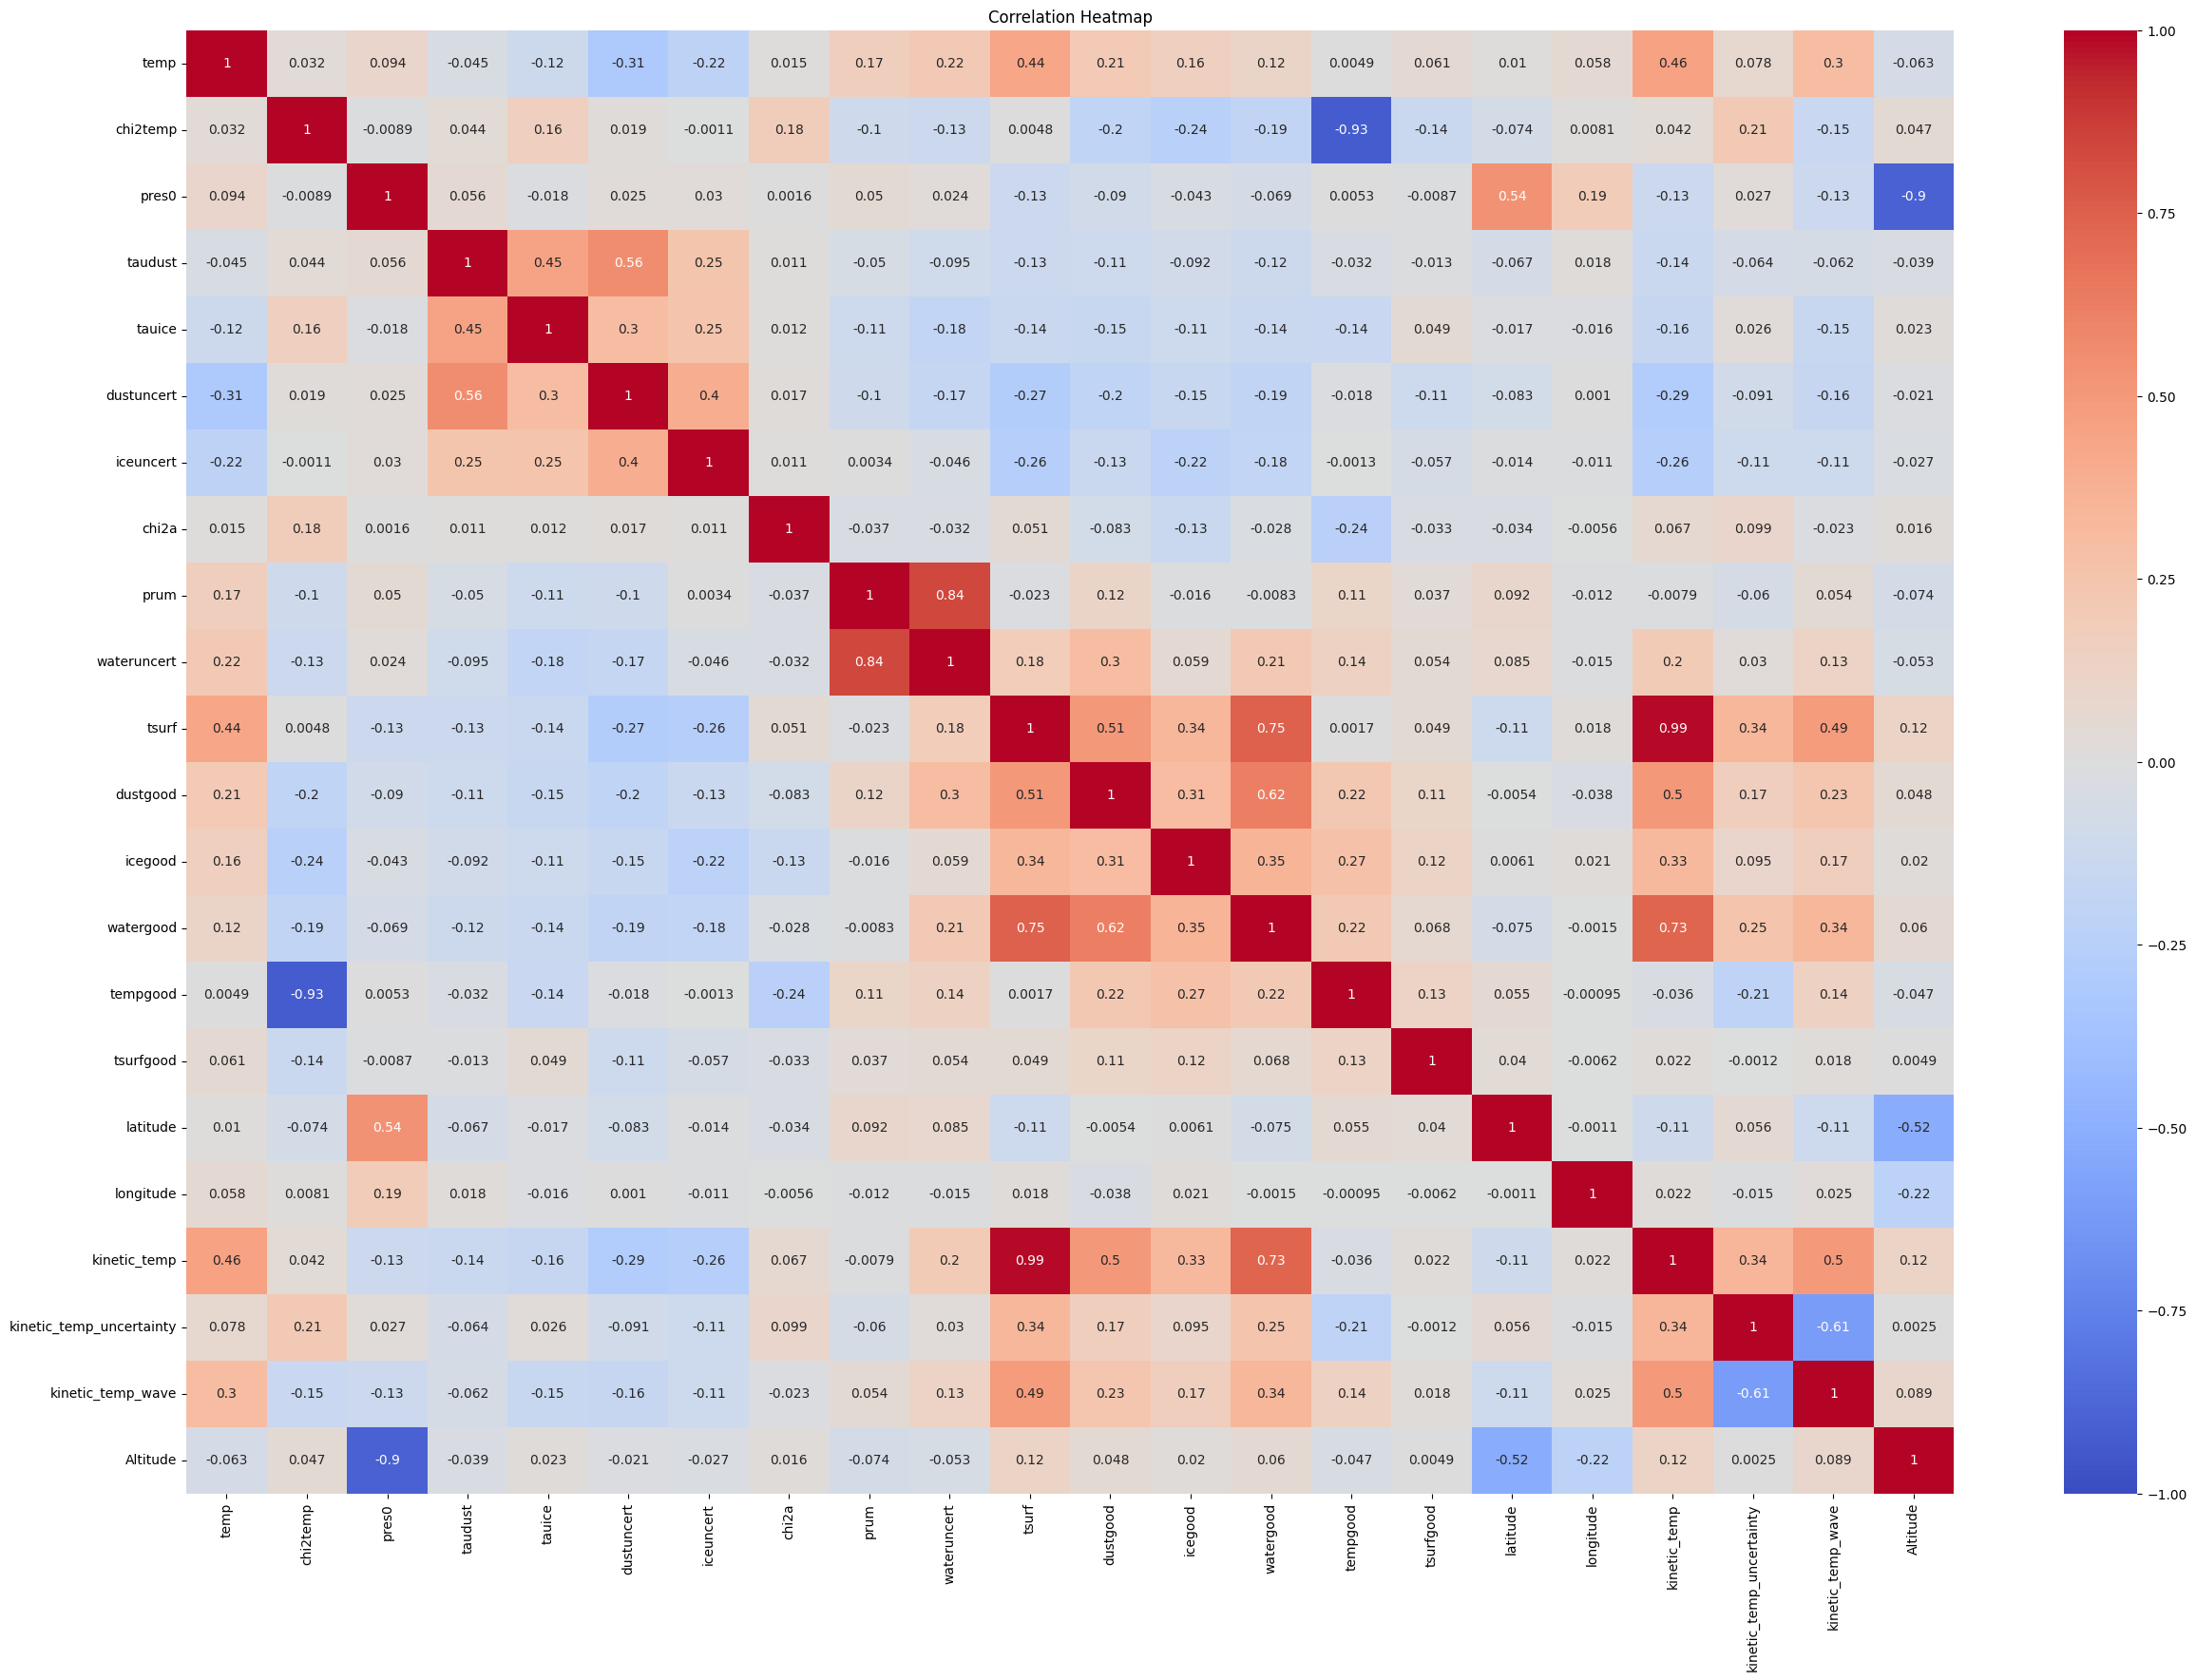

In [17]:
plt.figure(figsize=(30, 20))

# Draw the heatmap with Seaborn
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)

# Add title and labels
plt.title('Correlation Heatmap')
plt.show()